In [1]:
import pandas as pd
from functools import reduce
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# загружаем данные от ПОРА
pora_df = pd.read_excel('Data_SberIndex_POAD.xlsx', sheet_name='Данные')
territory = pd.read_csv(
    'territory_id_pora.csv',
    sep=';',
    encoding='cp1251',
    engine='python'   
)

In [3]:
# загружаем данные от СберИндекса
beznal_df = pd.read_csv('dolya-beznala.csv', sep=';')
real_estate_primary_df = pd.read_csv('real_estate_deals_primary_market.csv', sep=';')
real_estate_secondary_df = pd.read_csv('real_estate_deals_secondary_market.csv', sep=';')
predlozheniya_vtor_df = pd.read_csv('predlozheniya-vtorichnoi-nedvizhimosti.csv', encoding='cp1251', sep=';')
predlozheniya_nov_df = pd.read_csv('predlozheniya-novostroek.csv', encoding='cp1251', sep=';')

In [4]:
# мерджим данные ПОРА и СберИндекс
pora = pora_df.merge(
    territory[['region', 'municipality_up_name_actual', 'settlement_name', 'territory_id']],
    left_on=['region', 'municipality_up_name', 'settlement_name'],
    right_on=['region', 'municipality_up_name_actual', 'settlement_name'],
    how='left'
)

In [5]:
# функция подсчета медианы для значений из каждого файла
def summarize(df, name):
    df.columns = df.columns.str.replace('"', '').str.strip()

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.replace('"', '').str.strip()
    

    # переименовываем category → region, если нужно
    if 'category' in df.columns and 'region' not in df.columns:
        df = df.rename(columns={'category': 'region'})


    if 'region' not in df.columns:
        raise KeyError(f'Нет колонки region в {name}')

    # конвертируем дату
    df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)

    result = []
    for region in regions:
        sub = df[df['region'].str.contains(region, case=False, na=False)]
        if sub.empty:
            continue
        median_val = sub['value'].median()
        result.append({
            'region': region,
            f'{name}_median': median_val
        })
    return pd.DataFrame(result)

# берем только выбранные регионы
regions = ['Архангельская область', 'Республика Карелия']

dfs_summary = [
    summarize(beznal_df, 'beznal'),
    summarize(real_estate_primary_df, 'real_estate_primary'),
    summarize(real_estate_secondary_df, 'real_estate_secondary'),
    summarize(predlozheniya_vtor_df, 'predlozheniya_vtor'),
    summarize(predlozheniya_nov_df, 'predlozheniya_nov')
]

# объединяем все сводки
sber_summary = reduce(lambda left, right: pd.merge(left, right, on='region', how='outer'), dfs_summary)

print('Сводная таблица по регионам:')
display(sber_summary)

Сводная таблица по регионам:


/var/folders/gg/zv00wt3d6hx3kb2fy_ghqjhr0000gn/T/ipykernel_10660/3398144850.py:18: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
/var/folders/gg/zv00wt3d6hx3kb2fy_ghqjhr0000gn/T/ipykernel_10660/3398144850.py:18: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)


,region,beznal_median,real_estate_primary_median,real_estate_secondary_median,predlozheniya_vtor_median,predlozheniya_nov_median
0,Архангельская область,64.1,80767.0,63331.0,2246.0,1862.0
1,Республика Карелия,67.0,71728.0,61723.0,894.0,297.0


In [6]:
# фильтруем данные ПОРА по нужным регионам
pora_two = pora[pora['region'].isin(regions)].copy()

# объединяем с ПОРА
pora_sber = pora_two.merge(sber_summary, on='region', how='left')

print('Итоговый датафрейм (ПОРА + СБЕР):')
pora_sber.head()


Итоговый датафрейм (ПОРА + СБЕР):


,region,municipality_up_name,municipality_down_name,settlement_name,settlement_name_sep,type,arctic,remote,special,suburb,...,2.2.1_air_quality_new,2.3.5_suitability_indigenous_binary_new,2.7_crime_experience_binary_new,municipality_up_name_actual,territory_id,beznal_median,real_estate_primary_median,real_estate_secondary_median,predlozheniya_vtor_median,predlozheniya_nov_median
0,Архангельская область,Пинежский муниципальный район,Карпогорское сельское поселение,село Карпогоры,село Карпогоры (Архангельская область),село,True,False,ОНП,False,...,NaN,NaN,NaN,NaN,NaN,64.1,80767.0,63331.0,2246.0,1862.0
1,Архангельская область,Вельский муниципальный район,Городское поселение Кулойское,рп Кулой,рп Кулой (Архангельская область),рп,False,False,ПНП,False,...,NaN,NaN,NaN,Вельский муниципальный район,897.0,64.1,80767.0,63331.0,2246.0,1862.0
2,Архангельская область,Приморский муниципальный район,Уемское сельское поселение,поселок Уемский,поселок Уемский (Архангельская область),поселок,True,False,ПНП,True,...,2.914894,0.787234,0.510638,NaN,NaN,64.1,80767.0,63331.0,2246.0,1862.0
3,Республика Карелия,Медвежьегорский муниципальный район,Пиндушское городское поселение,пгт Пиндуши,пгт Пиндуши (Республика Карелия),пгт,False,False,ПНП,True,...,NaN,NaN,NaN,Медвежьегорский муниципальный район,214.0,67.0,71728.0,61723.0,894.0,297.0
4,Республика Карелия,Лоухский муниципальный район,Лоухское городское поселение,пгт Лоухи,пгт Лоухи (Республика Карелия),пгт,True,False,ОНП,False,...,3.750000,0.944444,0.361111,Лоухский муниципальный район,213.0,67.0,71728.0,61723.0,894.0,297.0


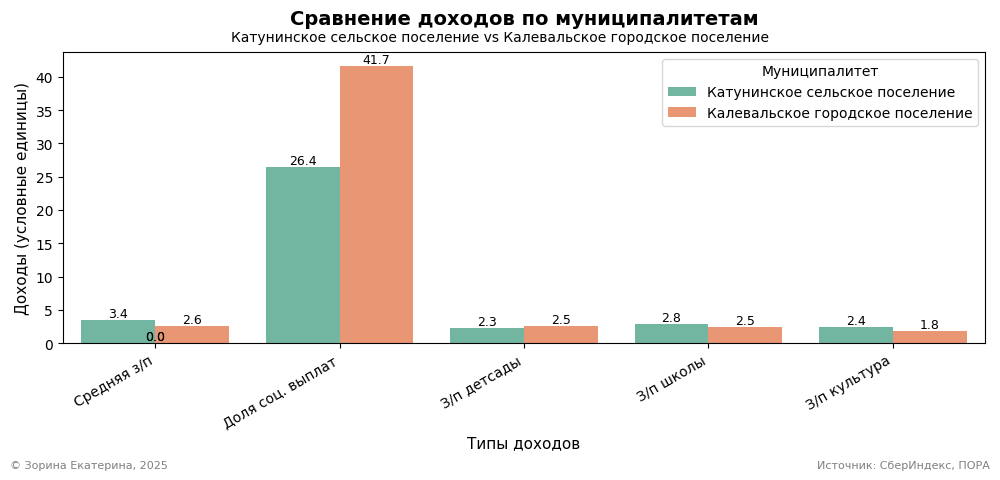

In [7]:
# выбираем нужные муниципалитеты нижнего уровня
municipalities = ['Катунинское сельское поселение', 'Калевальское городское поселение']
indicators = ['wage_average', 'social_share', 'kindergarden_salary', 'school_salary', 'culture_salary']

indicator_names = {
    'wage_average': 'Средняя з/п',
    'social_share': 'Доля соц. выплат',
    'kindergarden_salary': 'З/п детсады',
    'school_salary': 'З/п школы',
    'culture_salary': 'З/п культура'
}

# фильтруем строки и столбцы
df_plot = pora_sber[pora_sber['municipality_down_name'].isin(municipalities)][['municipality_down_name'] + indicators].copy()

for col in indicators:
    df_plot[col] = df_plot[col].astype(str).str.replace(',', '.').astype(float)

# меняем названия столбцов на русские
df_plot.rename(columns=indicator_names, inplace=True)

# превращаем в длинный формат
df_melted = df_plot.melt(id_vars='municipality_down_name', var_name='indicator', value_name='value')

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_melted,
    x='indicator',
    y='value',
    hue='municipality_down_name',
    palette='Set2'
)

plt.title('Сравнение доходов по муниципалитетам', fontsize=14, fontweight='bold', pad=20)
plt.suptitle('Катунинское сельское поселение vs Калевальское городское поселение', fontsize=10, y=0.87)
plt.xlabel('Типы доходов', fontsize=11)
plt.ylabel('Доходы (условные единицы)', fontsize=11)
plt.xticks(rotation=30, ha='right')
plt.legend(title='Муниципалитет', loc='upper right')

for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(f'{height:.1f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, rotation=0)

# футер
plt.figtext(0.01, -0.01, '© Зорина Екатерина, 2025',ha='left', va='bottom', fontsize=8, color='gray')
plt.figtext(0.99, -0.01, 'Источник: СберИндекс, ПОРА',ha='right', va='bottom', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

Катунинское сельское поселение имеет выше средние показатели по зарплатам во всех категориях. Доля социальных выплат в доходах населения — относительно низкая (26,4%), что может указывать на более стабильное финансовое положение жителей.

Калевальское городское поселение показывает ниже средние показатели по зарплатам. При этом доля социальных выплат — высокая (41,7%), что говорит о большей зависимости части населения от социальных трансфертов.

Вывод: Катунинское поселение выглядит финансово более устойчивым, с более высокими доходами населения, тогда как Калевальское поселение имеет более низкие зарплаты и большую долю социальных выплат, что может указывать на более уязвимую экономическую ситуацию.

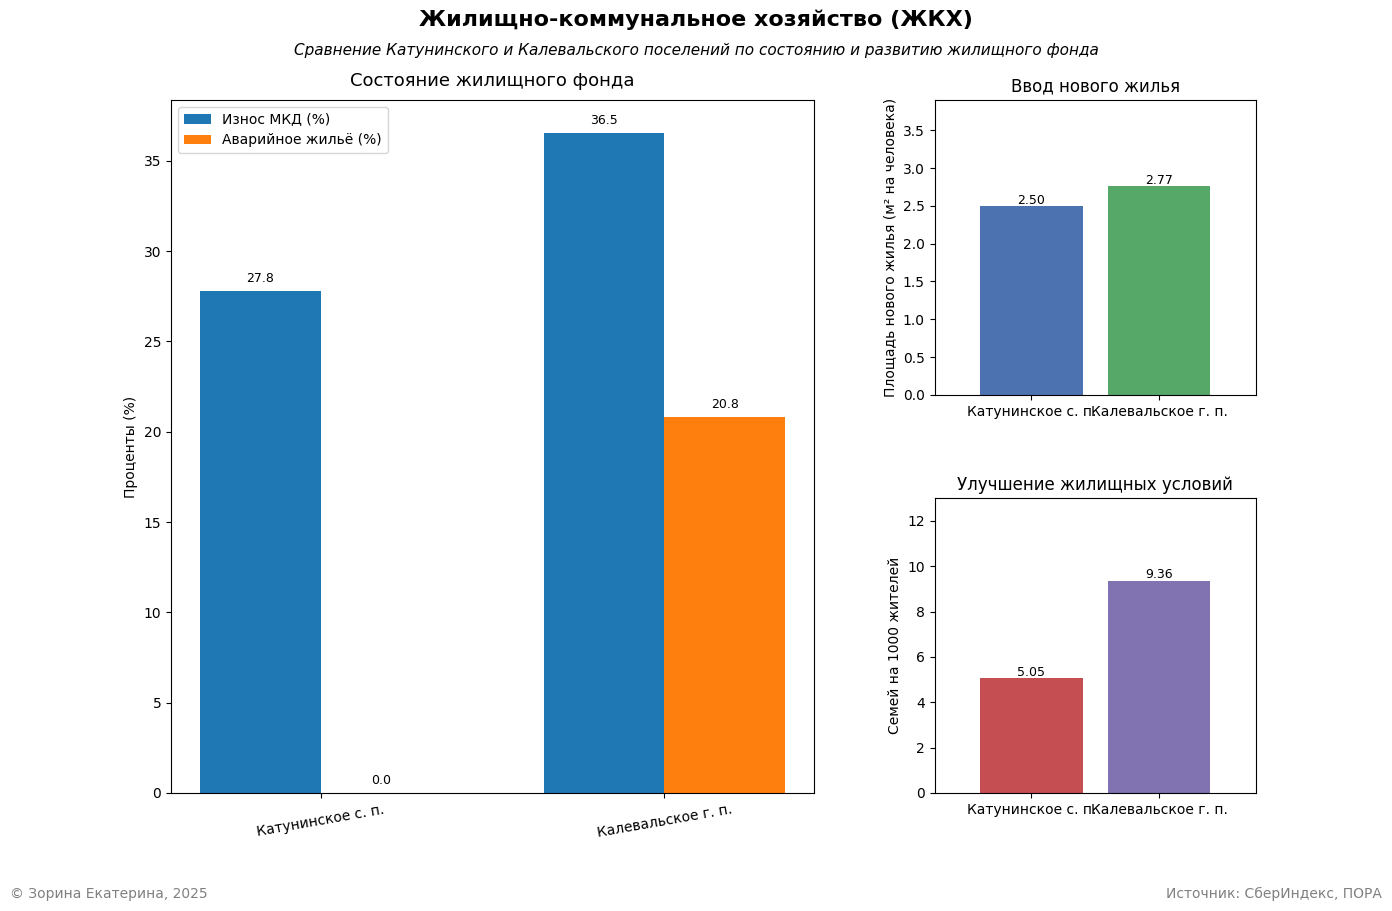

In [8]:
settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

indicators = ['housing_depreciation', 'emergency_housing', 'building_construction_space', 'families_improve']

# извлекаем данные
df_plot = pora_sber[pora_sber['municipality_down_name'].isin(settlements_full)][['municipality_down_name'] + indicators].copy()

for col in indicators:
    df_plot[col] = df_plot[col].astype(str).str.replace(',', '.').astype(float)

fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])
fig.subplots_adjust(wspace=0.25, hspace=0.35)

# левая большая таблица
ax1 = fig.add_subplot(gs[:, 0])
x = np.arange(len(settlements_short))
width = 0.35

ax1.bar(x - width/2, df_plot['housing_depreciation'], width, label='Износ МКД (%)')
ax1.bar(x + width/2, df_plot['emergency_housing'], width, label='Аварийное жильё (%)')

for i, v in enumerate(df_plot['housing_depreciation']):
    ax1.text(i - width/2, v + 0.5, f"{v:.1f}", ha='center', fontsize=9)
for i, v in enumerate(df_plot['emergency_housing']):
    ax1.text(i + width/2, v + 0.5, f"{v:.1f}", ha='center', fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels(settlements_short, rotation=10, ha='center')
ax1.set_ylabel('Проценты (%)')
ax1.set_title('Состояние жилищного фонда', fontsize=13, pad=10)
ax1.legend()

# правая верхняя таблица
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(settlements_short, df_plot['building_construction_space'], color=['#4C72B0', '#55A868'])
for i, v in enumerate(df_plot['building_construction_space']):
    ax2.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)
ax2.set_ylabel('Площадь нового жилья (м² на человека)')
ax2.margins(x=0.2)
ax2.set_ylim(0, 3 * 1.3)
ax2.set_title('Ввод нового жилья', fontsize=12)

# правая нижняя таблица
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(settlements_short, df_plot['families_improve'], color=['#C44E52', '#8172B2'])
for i, v in enumerate(df_plot['families_improve']):
    ax3.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=9)
ax3.set_ylabel('Семей на 1000 жителей')
ax3.margins(x=0.2)
ax3.set_ylim(0, 10 * 1.3)
ax3.set_title('Улучшение жилищных условий', fontsize=12, y=1)

fig.suptitle('Жилищно-коммунальное хозяйство (ЖКХ)', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93, 'Сравнение Катунинского и Калевальского поселений по состоянию и развитию жилищного фонда', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, -0.01, '© Зорина Екатерина, 2025', ha='left', va='bottom', fontsize=10, color='gray')
plt.figtext(0.99, -0.01, 'Источник: СберИндекс, ПОРА', ha='right', va='bottom', fontsize=10, color='gray')

plt.show()

Следует учитывать, что информация об износе многоквартирных домов в системе ГИС ЖКХ может быть неполной, поэтому данные по износу и аварийности следует рассматривать как ориентировочные.

В целом, ситуация в Калевальском поселении выглядит менее благополучной, чем в Катунинском: темпы строительства практически такие же, как в Катунинском районе, при том, что обеспеченность жильём на человека меньше почти в три раза. Число семей улучшивших жилищные условия выше, но это не главный показатель. Также в Калевальском поселении хуже состояние существующего жилищного фонда, что указывает на дефицит качественного жилого пространства и необходимость комплексного обновления жилого фонда.

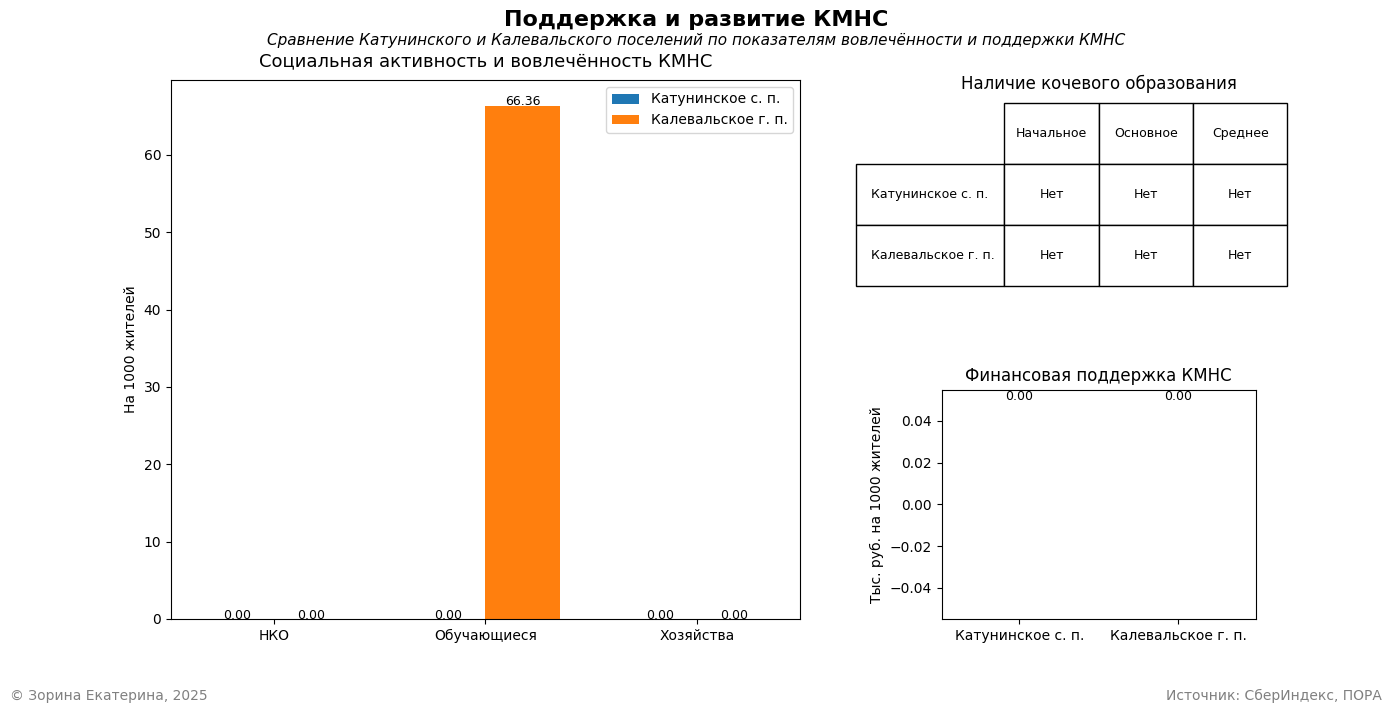

In [9]:
settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

indicators = [
    'nomadic_education_primary', 'nomadic_education_main', 'nomadic_education_high',
    'nomadic_ngo', 'nomadic_language', 'nomadic_firms', 'nomadic_support'
]

df_plot = pora_sber[pora_sber['municipality_down_name'].isin(settlements_full)][[
    'municipality_down_name'] + indicators].copy()

for col in ['nomadic_education_primary', 'nomadic_education_main', 'nomadic_education_high']:
    df_plot[col] = df_plot[col].replace({'Да': 1, 'Нет': 0, 'да': 1, 'нет': 0})

for col in ['nomadic_ngo', 'nomadic_language', 'nomadic_firms', 'nomadic_support']:
    df_plot[col] = df_plot[col].astype(str).str.replace(',', '.').astype(float)

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])
fig.subplots_adjust(wspace=0.3, hspace=0.35)

# левая таблица
ax1 = fig.add_subplot(gs[:, 0])
x = np.arange(len(['НКО', 'Обучающиеся', 'Хозяйства']))
width = 0.35

cat_vals = ['nomadic_ngo', 'nomadic_language', 'nomadic_firms']

ax1.bar(x - width/2, df_plot[df_plot['municipality_down_name'] == settlements_full[0]][cat_vals].values[0], width, label=settlements_short[0])
ax1.bar(x + width/2, df_plot[df_plot['municipality_down_name'] == settlements_full[1]][cat_vals].values[0], width, label=settlements_short[1])

for i, col in enumerate(cat_vals):
    v1 = df_plot[df_plot['municipality_down_name'] == settlements_full[0]][col].values[0]
    v2 = df_plot[df_plot['municipality_down_name'] == settlements_full[1]][col].values[0]
    ax1.text(i - width/2, v1 + 0.05, f"{v1:.2f}", ha='center', fontsize=9)
    ax1.text(i + width/2, v2 + 0.05, f"{v2:.2f}", ha='center', fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels(['НКО', 'Обучающиеся', 'Хозяйства'])
ax1.set_ylabel('На 1000 жителей')
ax1.set_title('Социальная активность и вовлечённость КМНС', fontsize=13, pad=10)
ax1.legend()

# правая верхняя таблица
ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')

table_data = df_plot[['nomadic_education_primary',
                      'nomadic_education_main',
                      'nomadic_education_high']].replace({1: 'Да', 0: 'Нет'}).values

table = ax2.table(
    cellText=table_data,
    rowLabels=settlements_short,
    colLabels=['Начальное', 'Основное', 'Среднее'],
    cellLoc='center',
    loc='center',
    bbox=[0.2, 0.1, 0.9, 0.8]
)

table.scale(1.2, 1.8)

ax2.set_title('Наличие кочевого образования', fontsize=12, pad=10, y=0.9)

# правая нижняя таблица
ax3 = fig.add_subplot(gs[1, 1])
vals = df_plot['nomadic_support'].values
ax3.bar(settlements_short, vals, color=['#C44E52', '#8172B2'])
for i, v in enumerate(vals):
    ax3.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=9)
ax3.set_ylabel('Тыс. руб. на 1000 жителей')
ax3.set_title('Финансовая поддержка КМНС', fontsize=12, y=1)

fig.suptitle('Поддержка и развитие КМНС', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93, 'Сравнение Катунинского и Калевальского поселений по показателям вовлечённости и поддержки КМНС', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, -0.01, '© Зорина Екатерина, 2025', ha='left', va='bottom', fontsize=10, color='gray')
plt.figtext(0.99, -0.01, 'Источник: СберИндекс, ПОРА', ha='right', va='bottom', fontsize=10, color='gray')

plt.show()

В обоих поселениях — Катунинском и Калевальском — отсутствуют возможности оказания образовательных услуг кочевым образом на всех уровнях: начальном, основном и среднем. Также нет зарегистрированных некоммерческих организаций, занимающихся поддержкой КМНС, и не реализуются меры финансовой поддержки традиционных видов хозяйственной деятельности.

Единственное отличие наблюдается по показателю обучающихся на языках коренных народов — в Калевальском поселении этот показатель составляет 66,36 на 1000 жителей, что говорит о наличии интереса к сохранению и развитию этнокультурной идентичности через систему образования. В Катунинском поселении таких обучающихся нет вовсе.

В целом ситуация в Калевальском поселении лишь немного лучше, поскольку наблюдается образовательная активность в сфере языков КМНС, однако по остальным направлениям — организации кочевого образования, развитию хозяйственных инициатив и поддержке КМНС — положение остаётся одинаково слабым в обоих поселениях.

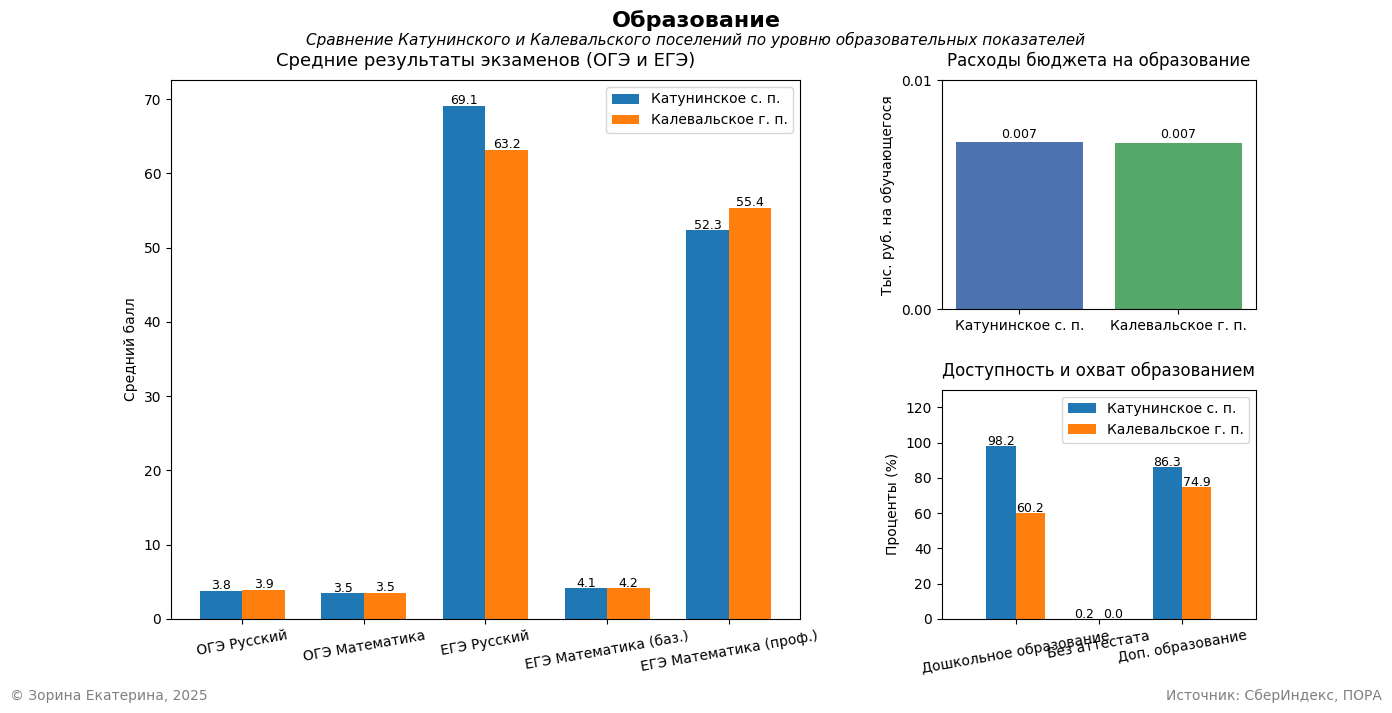

In [10]:
width_ratios = [2.0, 1.0]
height_ratios = [1.0, 1.0]
spendings_tick_step = 0.01
figsize = (14, 7)

settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

indicators = [
    'kindergardens_availability', 'certificate_fail', 'russian_oge', 'math_oge',
    'russian_ege', 'math_ege_base', 'math_ege_plus', 'spendings_per_schoolar',
    'additional_education'
]

df_plot = pora_sber[pora_sber['municipality_down_name'].isin(settlements_full)][['municipality_down_name'] + indicators].copy()

for col in indicators:
    df_plot[col] = df_plot[col].astype(str).str.replace(',', '.').astype(float)

fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(2, 2, width_ratios=width_ratios, height_ratios=height_ratios)
fig.subplots_adjust(wspace=0.3, hspace=0.35)

# левая большая таблица
ax1 = fig.add_subplot(gs[:, 0])
exam_labels = ['ОГЭ Русский', 'ОГЭ Математика', 'ЕГЭ Русский', 'ЕГЭ Математика (баз.)', 'ЕГЭ Математика (проф.)']
exam_cols = ['russian_oge', 'math_oge', 'russian_ege', 'math_ege_base', 'math_ege_plus']
x = np.arange(len(exam_labels))
width = 0.35

vals_left_0 = df_plot[df_plot['municipality_down_name'] == settlements_full[0]][exam_cols].values[0]
vals_left_1 = df_plot[df_plot['municipality_down_name'] == settlements_full[1]][exam_cols].values[0]

ax1.bar(x - width/2, vals_left_0, width, label=settlements_short[0])
ax1.bar(x + width/2, vals_left_1, width, label=settlements_short[1])

for i, col in enumerate(exam_cols):
    v1 = vals_left_0[i]
    v2 = vals_left_1[i]
    ax1.text(i - width/2, v1 + 0.2, f"{v1:.1f}", ha='center', fontsize=9)
    ax1.text(i + width/2, v2 + 0.2, f"{v2:.1f}", ha='center', fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels(exam_labels, rotation=10, ha='center')
ax1.set_ylabel('Средний балл')
ax1.set_title('Средние результаты экзаменов (ОГЭ и ЕГЭ)', fontsize=13, pad=10)
ax1.legend()

# правая верхняя таблица
ax2 = fig.add_subplot(gs[0, 1])
vals_spend = df_plot['spendings_per_schoolar'].values.astype(float)

ymax = max(vals_spend.max()*1.2, spendings_tick_step)
ax2.bar(settlements_short, vals_spend, color=['#4C72B0', '#55A868'])

for i, v in enumerate(vals_spend):
    ax2.text(i, v + ymax * 0.02, f"{v:.3f}", ha='center', fontsize=9)

ax2.set_ylabel('Тыс. руб. на обучающегося')
ax2.set_title('Расходы бюджета на образование', fontsize=12, pad=10, y=1)

ticks = np.arange(0, ymax + 1e-9, spendings_tick_step)
if len(ticks) > 12:
    step = np.ceil((ticks[-1] / 12) / spendings_tick_step) * spendings_tick_step
    ticks = np.arange(0, ymax + step, step)
ax2.set_yticks(ticks)
ax2.set_ylim(0, ticks[-1])

# правая нижняя таблица
ax3 = fig.add_subplot(gs[1, 1])
share_labels = ['Дошкольное образование', 'Без аттестата', 'Доп. образование']
share_cols = ['kindergardens_availability', 'certificate_fail', 'additional_education']

x2 = np.arange(len(share_labels))
vals_share_0 = df_plot[df_plot['municipality_down_name'] == settlements_full[0]][share_cols].values[0]
vals_share_1 = df_plot[df_plot['municipality_down_name'] == settlements_full[1]][share_cols].values[0]

ax3.bar(x2 - width/2, vals_share_0, width, label=settlements_short[0])
ax3.bar(x2 + width/2, vals_share_1, width, label=settlements_short[1])

for i, col in enumerate(share_cols):
    v1 = vals_share_0[i]
    v2 = vals_share_1[i]
    ax3.text(i - width/2, v1 + 0.5, f"{v1:.1f}", ha='center', fontsize=9)
    ax3.text(i + width/2, v2 + 0.5, f"{v2:.1f}", ha='center', fontsize=9)

ax3.set_xticks(x2)
ax3.margins(x=0.2)
ax3.set_ylim(0, 100 * 1.3)
ax3.set_xticklabels(share_labels, rotation=10, ha='center')
ax3.set_ylabel('Проценты (%)')
ax3.set_title('Доступность и охват образованием', fontsize=12, pad=10)
ax3.legend()

fig.suptitle('Образование', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93, 'Сравнение Катунинского и Калевальского поселений по уровню образовательных показателей', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, -0.01, '© Зорина Екатерина, 2025', ha='left', va='bottom', fontsize=10, color='gray')
plt.figtext(0.99, -0.01, 'Источник: СберИндекс, ПОРА', ha='right', va='bottom', fontsize=10, color='gray')

plt.show()

В Катунинском поселении наблюдается более высокая обеспеченность дошкольным образованием — 98,2 % детей получают соответствующие услуги, что почти на 38 процентных пунктов выше, чем в Калевальском (60,2 %). Это говорит о лучшей доступности детских садов и, вероятно, о более сбалансированной инфраструктуре для семей с детьми.

Доля выпускников, не получивших аттестат, в обоих поселениях крайне мала и не превышает 0,2 %, что свидетельствует о достаточно высоком уровне удержания учащихся в школах.

Показатели по результатам экзаменов (ОГЭ и ЕГЭ) близки между поселениями:

по русскому языку у катунинских школьников средние результаты немного выше (ОГЭ — 3,8 против 3,9 в Калевальском, ЕГЭ — 69,1 против 63,2),

по математике результаты схожие (ОГЭ — 3,5 и 3,6, ЕГЭ базовый — 4,1 и 4,2), однако на профильном уровне ЕГЭ калевальские выпускники немного опережают катунинских (55,4 против 52,3).

Расходы бюджета на образование в обоих поселениях одинаковы (0,07 тыс. руб. на обучающегося в расчётных единицах), что позволяет говорить об одинаковом уровне бюджетного обеспечения системы образования.

По охвату дополнительным образованием Катунинское поселение также показывает более высокий результат — 86,3 % против 74,9 %, что указывает на более развитую сеть кружков и секций.

Итог:
В целом система образования в Катунинском поселении выглядит более устойчивой и комплексно развитой, с высоким охватом дошкольных учреждений и дополнительного образования, а также достойными результатами по итоговой аттестации. Калевальское поселение, напротив, демонстрирует более слабые позиции по охвату и качеству образования, несмотря на схожий уровень бюджетных расходов. Это может свидетельствовать о необходимости совершенствования образовательной инфраструктуры и программ развития в Калевальском поселении.

posx and posy should be finite values
posx and posy should be finite values


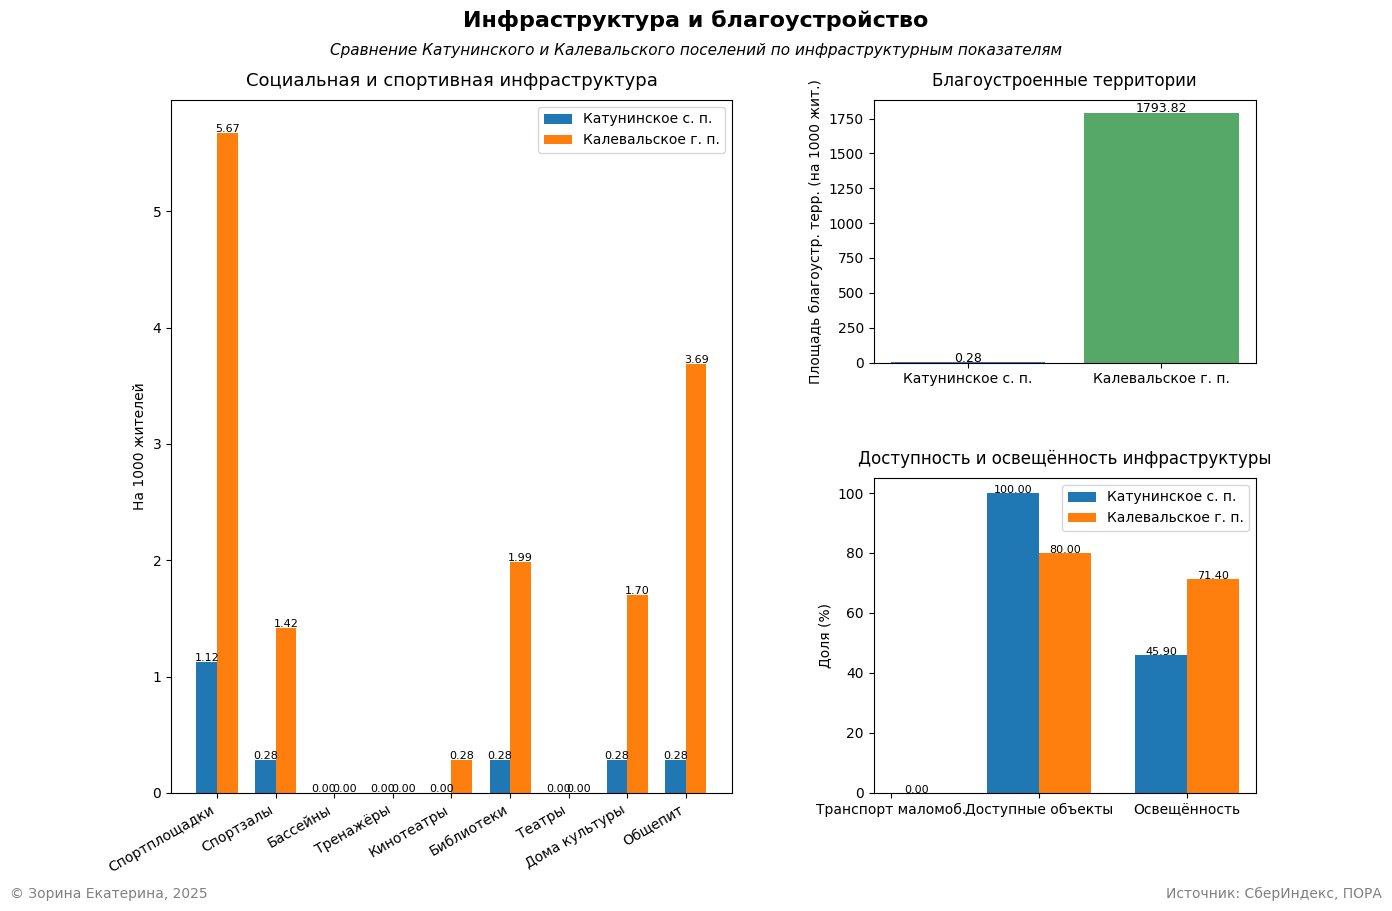

In [11]:
settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

quantity_indicators = [
    'sport_facilities', 'sport_halls', 'sport_pools', 'sport_gym',
    'cinemas', 'libraries', 'theatres', 'culture_centers', 'catering'
]
improving_indicator = ['improving_facilities']
share_indicators = ['disabled_transport', 'disabled_buildings', 'lighting']

df_plot = pora_sber[pora_sber['municipality_down_name'].isin(settlements_full)][
    ['municipality_down_name'] + quantity_indicators +
    improving_indicator + share_indicators
].copy()

for col in quantity_indicators + improving_indicator + share_indicators:
    df_plot[col] = df_plot[col].astype(str).str.replace(',', '.').astype(float)

left_width = 2.2
right_width = 1.5
top_height = 1.0
bottom_height = 1.2

fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(
    2, 2,
    width_ratios=[left_width, right_width],
    height_ratios=[top_height, bottom_height]
)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

# левая таблица
ax1 = fig.add_subplot(gs[:, 0])
x = np.arange(len(quantity_indicators))
width = 0.35

vals1 = df_plot[df_plot['municipality_down_name'] == settlements_full[0]][quantity_indicators].values[0]
vals2 = df_plot[df_plot['municipality_down_name'] == settlements_full[1]][quantity_indicators].values[0]

ax1.bar(x - width/2, vals1, width, label=settlements_short[0])
ax1.bar(x + width/2, vals2, width, label=settlements_short[1])

for i in range(len(x)):
    ax1.text(i - width/2, vals1[i] + 0.01, f"{vals1[i]:.2f}", ha='center', fontsize=8)
    ax1.text(i + width/2, vals2[i] + 0.01, f"{vals2[i]:.2f}", ha='center', fontsize=8)

ax1.set_xticks(x)
ax1.set_xticklabels([
    'Спортплощадки', 'Спортзалы', 'Бассейны', 'Тренажёры', 'Кинотеатры',
    'Библиотеки', 'Театры', 'Дома культуры', 'Общепит'
], rotation=30, ha='right')
ax1.set_ylabel('На 1000 жителей')
ax1.set_title('Социальная и спортивная инфраструктура', fontsize=13, pad=10)
ax1.legend()

# правая верхняя таблица
ax2 = fig.add_subplot(gs[0, 1])
vals = df_plot[improving_indicator].values.flatten()
ax2.bar(settlements_short, vals, color=['#4C72B0', '#55A868'])
for i, v in enumerate(vals):
    ax2.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)
ax2.set_ylabel('Площадь благоустр. терр. (на 1000 жит.)')
ax2.set_title('Благоустроенные территории', fontsize=12, pad=10)

# правая нижняя таблица
ax3 = fig.add_subplot(gs[1, 1])
x2 = np.arange(len(share_indicators))
width2 = 0.35

vals1_2 = df_plot[df_plot['municipality_down_name'] == settlements_full[0]][share_indicators].values[0]
vals2_2 = df_plot[df_plot['municipality_down_name'] == settlements_full[1]][share_indicators].values[0]

ax3.bar(x2 - width2/2, vals1_2, width2, label=settlements_short[0])
ax3.bar(x2 + width2/2, vals2_2, width2, label=settlements_short[1])

for i in range(len(x2)):
    ax3.text(i - width2/2, vals1_2[i] + 0.01, f"{vals1_2[i]:.2f}", ha='center', fontsize=8)
    ax3.text(i + width2/2, vals2_2[i] + 0.01, f"{vals2_2[i]:.2f}", ha='center', fontsize=8)

ax3.set_xticks(x2)
ax3.set_xticklabels(['Транспорт маломоб.', 'Доступные объекты', 'Освещённость'])
ax3.set_ylabel('Доля (%)')
ax3.set_title('Доступность и освещённость инфраструктуры', fontsize=12, pad=10)
ax3.legend()

fig.suptitle('Инфраструктура и благоустройство', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93,
         'Сравнение Катунинского и Калевальского поселений по инфраструктурным показателям',
         ha='center', fontsize=11, style='italic')

plt.figtext(0.01, -0.01, '© Зорина Екатерина, 2025', ha='left', va='bottom', fontsize=10, color='gray')
plt.figtext(0.99, -0.01, 'Источник: СберИндекс, ПОРА', ha='right', va='bottom', fontsize=10, color='gray')

plt.show()

В Катунинском сельском поселении инфраструктура развита в крайне ограниченных масштабах: на 1000 жителей приходится в среднем лишь около 1 спортивной площадки и 0,3 спортивного зала, при отсутствии бассейнов, тренажёрных залов и кинотеатров. Также наблюдается низкая обеспеченность культурными объектами — по 0,3 библиотеки и дома культуры на тысячу человек. Показатели благоустройства (0,3) указывают на минимальные темпы обновления и развития общественных пространств. При этом уровень доступности городской инфраструктуры 100%, но освещённость уличной сети ограничена (45,9%).

В Калевальском городском поселении инфраструктурная насыщенность заметно выше: плотность спортивных площадок и залов в 4–5 раз превышает показатели Катунинского, число библиотек и домов культуры также значительно больше. Показатель освещённости улиц достигает 71,4%, что говорит о лучшем качестве городской среды. При этом в данных зафиксировано аномально высокое значение благоустроенных территорий (1793,8 на 1000 жителей). В обоих поселениях нет транспорта для маломобильных граждан.

В целом, инфраструктурная обеспеченность Калевальского поселения выше, особенно в сфере спорта, культуры и благоустройства. При этом Катунинское поселение показывает лучшие результаты в доступности инфраструктуры, что может быть связано с компактностью территории и меньшими масштабами объектов. Однако развитие общественных пространств и культурной среды в Катунинском требует значительного усиления.

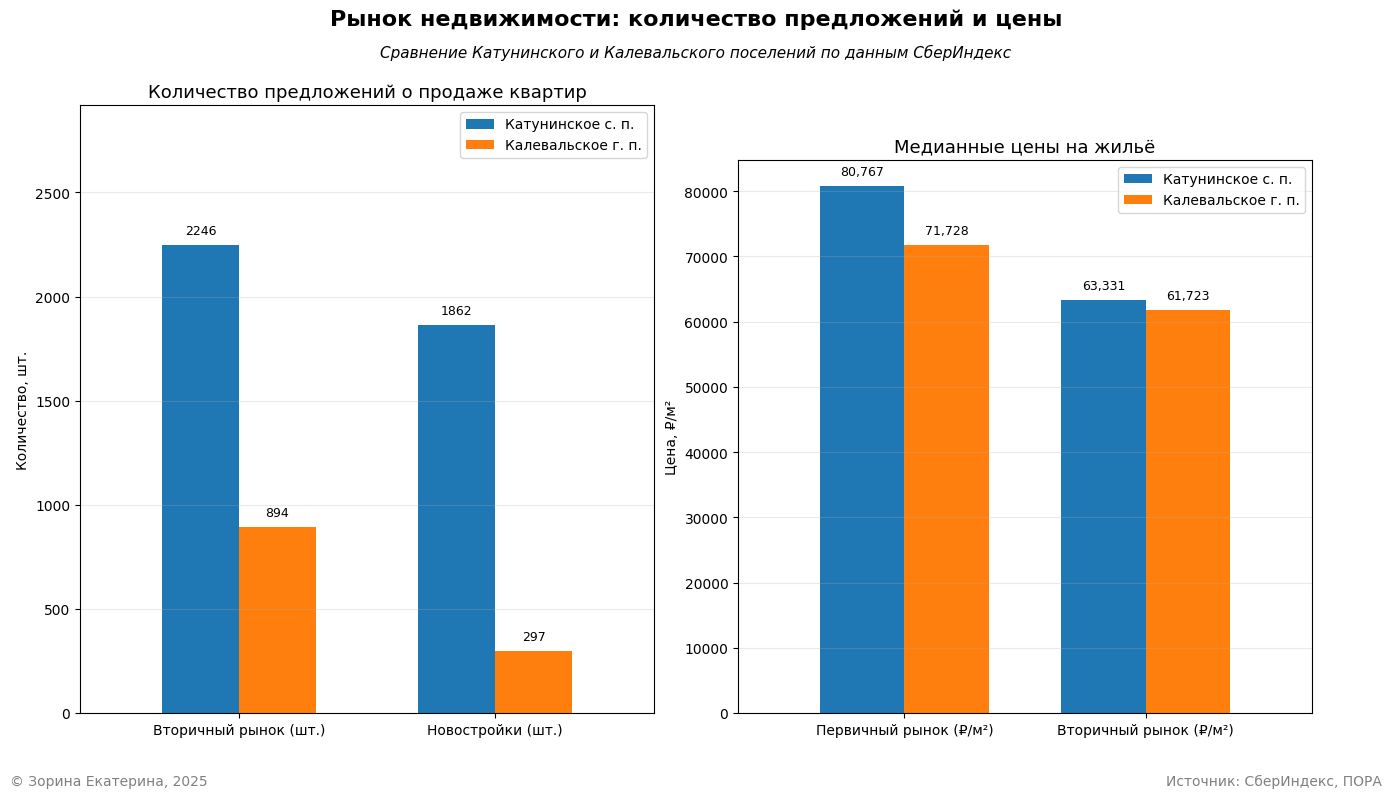

In [12]:
left_width = 1.0
right_width = 1.0
top_height = 0.1
bottom_height = 8.0

settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

settlement_col = 'municipality_down_name'

data = pora_sber.loc[
    pora_sber[settlement_col].isin(settlements_full),
    [
        settlement_col,
        'real_estate_primary_median',
        'real_estate_secondary_median',
        'predlozheniya_vtor_median',
        'predlozheniya_nov_median'
    ]
].set_index(settlement_col).T.to_dict(orient='list')

# расчёт относительных позиций
w_total = left_width + right_width
h_total = top_height + bottom_height

left_margin = 0.06
right_margin = 0.06
bottom_margin = 0.10
top_margin = 0.20
middle_gap = 0.06
vertical_gap = 0.06

avail_w = 1.0 - left_margin - right_margin - middle_gap
avail_h = 1.0 - top_margin - bottom_margin

left_w_frac = (left_width / w_total) * avail_w
right_w_frac = (right_width / w_total) * avail_w

top_h_frac = (top_height / h_total) * avail_h
bottom_h_frac = (bottom_height / h_total) * avail_h

left_pos = [left_margin, bottom_margin, left_w_frac, top_h_frac + bottom_h_frac + vertical_gap]
right_bottom_pos = [left_margin + left_w_frac + middle_gap, bottom_margin, right_w_frac, bottom_h_frac]

fig = plt.figure(figsize=(14, 8))

# левая таблица
ax1 = fig.add_axes(left_pos)
x = np.arange(2)
width = 0.3

b1 = ax1.bar(x - width/2,
             [data[settlements_full[0]][2], data[settlements_full[0]][3]],
             width, label=settlements_short[0])
b2 = ax1.bar(x + width/2,
             [data[settlements_full[1]][2], data[settlements_full[1]][3]],
             width, label=settlements_short[1])

for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax1.annotate(f"{h:.0f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x)
ax1.margins(x=0.2)
ax1.set_ylim(0, 2246 * 1.3)
ax1.set_xticklabels(['Вторичный рынок (шт.)', 'Новостройки (шт.)'])
ax1.set_ylabel('Количество, шт.')
ax1.set_title('Количество предложений о продаже квартир', fontsize=13)
ax1.legend()
ax1.grid(axis='y', alpha=0.25)

# правая таблица
ax2 = fig.add_axes(right_bottom_pos)
x2 = np.arange(2)
width2 = 0.35

b21 = ax2.bar(x2 - width2/2,
              [data[settlements_full[0]][0], data[settlements_full[0]][1]],
              width2, label=settlements_short[0])
b22 = ax2.bar(x2 + width2/2,
              [data[settlements_full[1]][0], data[settlements_full[1]][1]],
              width2, label=settlements_short[1])

for bars in (b21, b22):
    for bar in bars:
        h = bar.get_height()
        ax2.annotate(f"{h:,.0f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax2.set_xticks(x2)
ax2.set_xticklabels(['Первичный рынок (₽/м²)', 'Вторичный рынок (₽/м²)'])
ax2.margins(x=0.2)
ax2.set_ylabel('Цена, ₽/м²')
ax2.set_title('Медианные цены на жильё', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.25)

fig.suptitle('Рынок недвижимости: количество предложений и цены', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.92, 'Сравнение Катунинского и Калевальского поселений по данным СберИндекс', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, 0.01, '© Зорина Екатерина, 2025', ha='left', fontsize=10, color='gray')
plt.figtext(0.99, 0.01, 'Источник: СберИндекс, ПОРА', ha='right', fontsize=10, color='gray')

plt.show()

Ситуация на рынке недвижимости в Катунинском поселении более развитая: большее количество предложений и более высокая активность как на первичном, так и на вторичном рынке. Калевальское поселение характеризуется меньшим объёмом предложений и чуть более низкими ценами, что указывает на менее активный и менее ликвидный рынок жилья. В целом, для покупателей Катунинское поселение предоставляет более широкий выбор жилья, тогда как Калевальское поселение — более ограниченные возможности с меньшей конкуренцией.

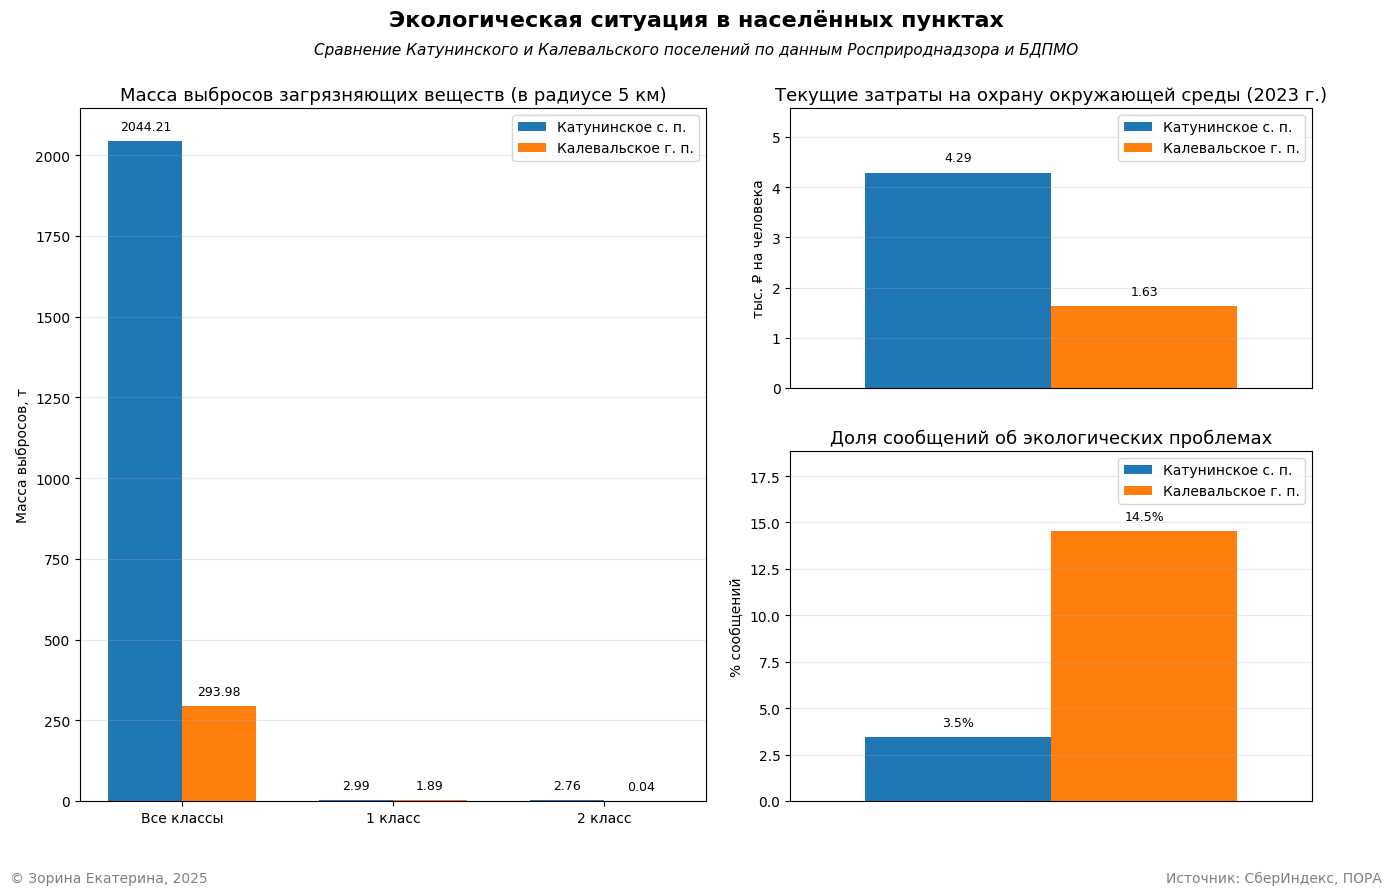

In [13]:
left_width = 1.2
right_width = 1.0
top_height = 0.8
bottom_height = 1.0

settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

settlement_col = 'municipality_down_name'

data = pora_sber.loc[
    pora_sber[settlement_col].isin(settlements_full),
    [
        settlement_col,
        'emissions_all',
        'emissions_first',
        'emissions_second',
        'ecology_spending',
        'comments_eco_perc'
    ]
].set_index(settlement_col).T.to_dict(orient='list')

# пропорции расположения
w_total = left_width + right_width
h_total = top_height + bottom_height

left_margin = 0.06
right_margin = 0.06
bottom_margin = 0.10
top_margin = 0.20
middle_gap = 0.06
vertical_gap = 0.07

avail_w = 1.0 - left_margin - right_margin - middle_gap
avail_h = 1.0 - top_margin - bottom_margin

left_w_frac = (left_width / w_total) * avail_w
right_w_frac = (right_width / w_total) * avail_w

top_h_frac = (top_height / h_total) * avail_h
bottom_h_frac = (bottom_height / h_total) * avail_h

left_pos = [left_margin, bottom_margin, left_w_frac, top_h_frac + bottom_h_frac + vertical_gap]
right_top_pos = [left_margin + left_w_frac + middle_gap, bottom_margin + bottom_h_frac + vertical_gap, right_w_frac, top_h_frac]
right_bottom_pos = [left_margin + left_w_frac + middle_gap, bottom_margin, right_w_frac, bottom_h_frac]

fig = plt.figure(figsize=(14, 9))

# левая таблица
ax1 = fig.add_axes(left_pos)
x = np.arange(3)
width = 0.35

b1 = ax1.bar(x - width/2,
             [data[settlements_full[0]][0],
              data[settlements_full[0]][1],
              data[settlements_full[0]][2]],
             width, label=settlements_short[0])
b2 = ax1.bar(x + width/2,
             [data[settlements_full[1]][0],
              data[settlements_full[1]][1],
              data[settlements_full[1]][2]],
             width, label=settlements_short[1])

for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax1.annotate(f"{h:.2f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels(['Все классы', '1 класс', '2 класс'])
ax1.set_ylabel('Масса выбросов, т')
ax1.set_title('Масса выбросов загрязняющих веществ (в радиусе 5 км)', fontsize=13)
ax1.legend()
ax1.grid(axis='y', alpha=0.25)

# правая верхняя таблица
ax2 = fig.add_axes(right_top_pos)
x2 = np.arange(1)
width2 = 0.35

b21 = ax2.bar(x2 - width2/2, [data[settlements_full[0]][3]], width2, label=settlements_short[0])
b22 = ax2.bar(x2 + width2/2, [data[settlements_full[1]][3]], width2, label=settlements_short[1])

for bars in (b21, b22):
    for bar in bars:
        h = bar.get_height()
        ax2.annotate(f"{h:,.2f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax2.set_xticks([])
ax2.set_ylabel('тыс. ₽ на человека')
ax2.margins(x=0.2)
ax2.set_ylim(0, 4.29 * 1.3)
ax2.set_title('Текущие затраты на охрану окружающей среды (2023 г.)', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.25)

# правая нижняя таблица
ax3 = fig.add_axes(right_bottom_pos)
x3 = np.arange(1)
width3 = 0.4

b31 = ax3.bar(x3 - width3/2, [data[settlements_full[0]][4]], width3, label=settlements_short[0])
b32 = ax3.bar(x3 + width3/2, [data[settlements_full[1]][4]], width3, label=settlements_short[1])

for bars in (b31, b32):
    for bar in bars:
        h = bar.get_height()
        ax3.annotate(f"{h:.1f}%", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax3.set_xticks([])
ax3.set_ylabel('% сообщений')
ax3.margins(x=0.2)
ax3.set_ylim(0, 14.5 * 1.3)
ax3.set_title('Доля сообщений об экологических проблемах', fontsize=13)
ax3.legend()
ax3.grid(axis='y', alpha=0.25)

fig.suptitle('Экологическая ситуация в населённых пунктах', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93, 'Сравнение Катунинского и Калевальского поселений по данным Росприроднадзора и БДПМО', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, 0.01, '© Зорина Екатерина, 2025', ha='left', fontsize=10, color='gray')
plt.figtext(0.99, 0.01, 'Источник: СберИндекс, ПОРА', ha='right', fontsize=10, color='gray')

plt.show()

Катунинское сельское поселение характеризуется значительно более высокими показателями выбросов загрязняющих веществ:
— общий объём выбросов составляет 2044,2 т, что в 7 раз выше, чем в Калевальском поселении;
— выбросы первого класса опасности — 3,0 т, второго — 2,8 т, что также заметно больше, чем у Калевальского, где показатели минимальны (1,9 т и 0,0 т соответственно).
При этом текущие затраты на охрану окружающей среды в Катунинском поселении более чем в 2,5 раза выше, чем в Калевальском.
Доля сообщений о наличии экологических проблем в соцсетях относительно невелика — 3,45%, что может говорить о низкой обеспокоенности населения или более эффективной работе коммунальных служб.

Калевальское городское поселение, напротив, имеет существенно меньшую нагрузку на окружающую среду по уровню выбросов (всего 294 т).
Однако доля сообщений в социальных сетях о наличии экологических проблем значительно выше — 14,53%, что может указывать на высокую чувствительность жителей к вопросам экологии, либо на наличие локальных проблем (например, несанкционированных свалок или неудовлетворительного состояния городской среды), не отражённых в статистике выбросов.

В целом, между двумя поселениями прослеживается контраст между объективными и субъективными показателями экологического состояния.
Катунинское поселение сталкивается с реально более высокой промышленной нагрузкой на окружающую среду, но при этом население реже сообщает об экологических проблемах.
Калевальское поселение, наоборот, имеет меньшие реальные выбросы, однако социальное восприятие экологической ситуации более негативное.
Это подчёркивает необходимость учитывать как экологические данные мониторинга, так и общественное мнение при формировании программ устойчивого развития и природоохранной политики.

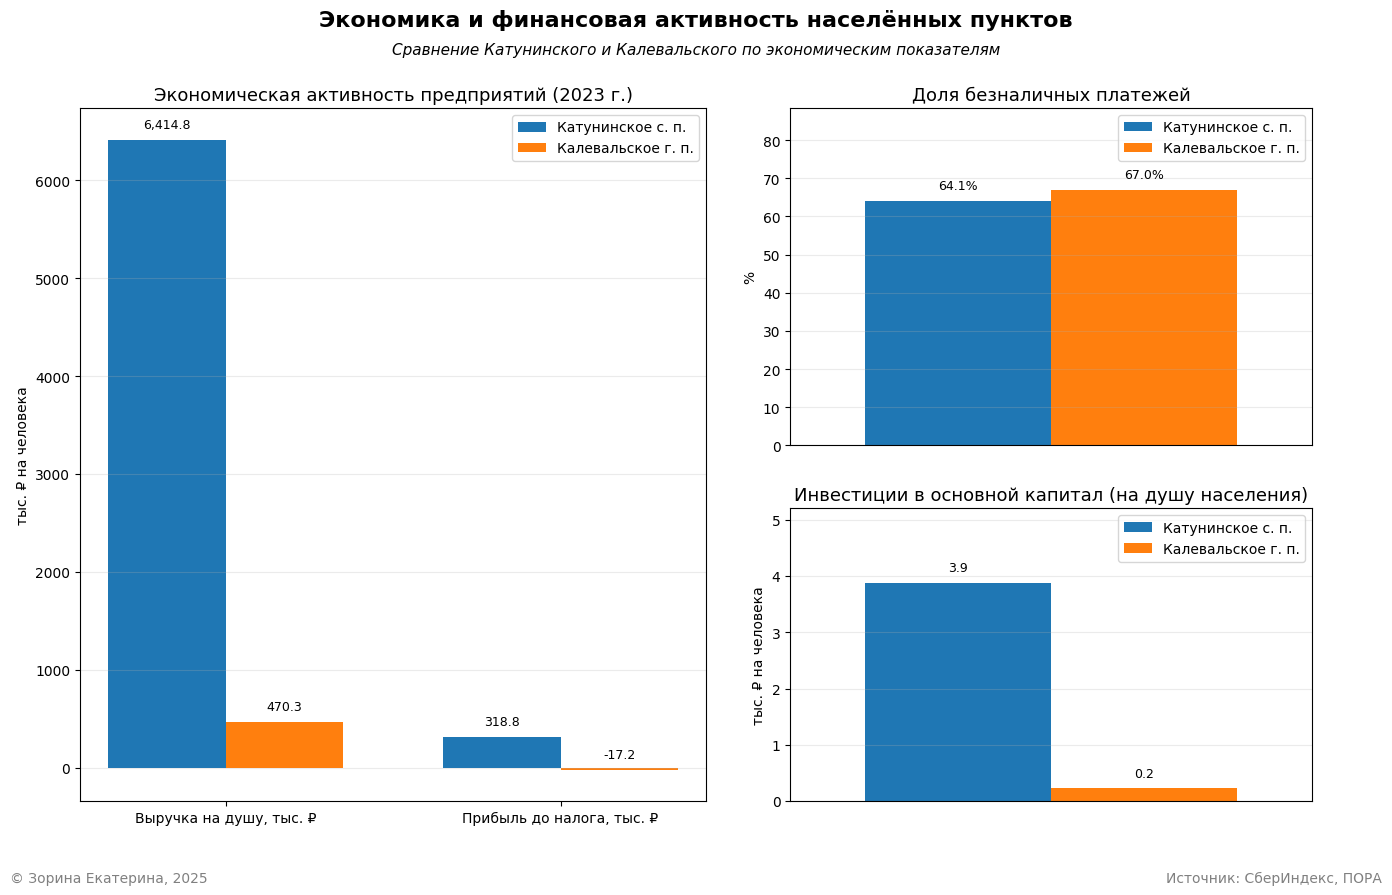

In [14]:
left_width = 1.2
right_width = 1.0
top_height = 1.5
bottom_height = 1.3

settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

settlement_col = 'municipality_down_name'

data = pora_sber.loc[
    pora_sber[settlement_col].isin(settlements_full),
    [
        settlement_col,
        'revenue_per_capita',
        'profit_bt_per_capita',
        'beznal_median',
        'investments_per_capita'
    ]
].set_index(settlement_col).T.to_dict(orient='list')

# пропорции расположения
w_total = left_width + right_width
h_total = top_height + bottom_height

left_margin = 0.06
right_margin = 0.06
bottom_margin = 0.10
top_margin = 0.20
middle_gap = 0.06
vertical_gap = 0.07

avail_w = 1.0 - left_margin - right_margin - middle_gap
avail_h = 1.0 - top_margin - bottom_margin

left_w_frac = (left_width / w_total) * avail_w
right_w_frac = (right_width / w_total) * avail_w

top_h_frac = (top_height / h_total) * avail_h
bottom_h_frac = (bottom_height / h_total) * avail_h

left_pos = [left_margin, bottom_margin, left_w_frac, top_h_frac + bottom_h_frac + vertical_gap]
right_top_pos = [left_margin + left_w_frac + middle_gap, bottom_margin + bottom_h_frac + vertical_gap, right_w_frac, top_h_frac]
right_bottom_pos = [left_margin + left_w_frac + middle_gap, bottom_margin, right_w_frac, bottom_h_frac]

fig = plt.figure(figsize=(14, 9))

# левая таблица
ax1 = fig.add_axes(left_pos)
x = np.arange(2)
width = 0.35

b1 = ax1.bar(x - width/2,
             [data[settlements_full[0]][0],
              data[settlements_full[0]][1]],
             width, label=settlements_short[0])
b2 = ax1.bar(x + width/2,
             [data[settlements_full[1]][0],
              data[settlements_full[1]][1]],
             width, label=settlements_short[1])

for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax1.annotate(f"{h:,.1f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels(['Выручка на душу, тыс. ₽', 'Прибыль до налога, тыс. ₽'])
ax1.set_ylabel('тыс. ₽ на человека')
ax1.set_title('Экономическая активность предприятий (2023 г.)', fontsize=13)
ax1.legend()
ax1.grid(axis='y', alpha=0.25)

# правая верхняя таблица
ax2 = fig.add_axes(right_top_pos)
x2 = np.arange(1)
width2 = 0.35

b21 = ax2.bar(x2 - width2/2, [data[settlements_full[0]][2]], width2, label=settlements_short[0])
b22 = ax2.bar(x2 + width2/2, [data[settlements_full[1]][2]], width2, label=settlements_short[1])

for bars in (b21, b22):
    for bar in bars:
        h = bar.get_height()
        ax2.annotate(f"{h:.1f}%", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax2.set_xticks([])
ax2.set_ylabel('%')
ax2.margins(x=0.2)
ax2.set_ylim(0, 68 * 1.3)
ax2.set_title('Доля безналичных платежей', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.25)

# правая нижняя таблица
ax3 = fig.add_axes(right_bottom_pos)
x3 = np.arange(1)
width3 = 0.4

b31 = ax3.bar(x3 - width3/2, [data[settlements_full[0]][3]], width3, label=settlements_short[0])
b32 = ax3.bar(x3 + width3/2, [data[settlements_full[1]][3]], width3, label=settlements_short[1])

for bars in (b31, b32):
    for bar in bars:
        h = bar.get_height()
        ax3.annotate(f"{h:,.1f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax3.set_xticks([])
ax3.set_ylabel('тыс. ₽ на человека')
ax3.margins(x=0.2)
ax3.set_ylim(0, 4 * 1.3)
ax3.set_title('Инвестиции в основной капитал (на душу населения)', fontsize=13)
ax3.legend()
ax3.grid(axis='y', alpha=0.25)

fig.suptitle('Экономика и финансовая активность населённых пунктов', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93, 'Сравнение Катунинского и Калевальского по экономическим показателям', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, 0.01, '© Зорина Екатерина, 2025', ha='left', fontsize=10, color='gray')
plt.figtext(0.99, 0.01, 'Источник: СберИндекс, ПОРА', ha='right', fontsize=10, color='gray')

plt.show()

Катунинское поселение демонстрирует сильную коммерческую базу: высокие выручки и особенно высокая прибыль на душу населения указывают на присутствие крупных/очень прибыльных предприятий, которые формируют экономическую устойчивость территории и обеспечивают инвестиции. Калевальское поселение, наоборот, выглядит слабее по экономической активности: очень низкие инвестиции и заметно меньшая прибыль. Особое внимание требует отрицательная выручка в данных по Калевале — это либо признак структурной проблемы (суммарные убытки у бизнеса), либо аномалия в исходных данных.

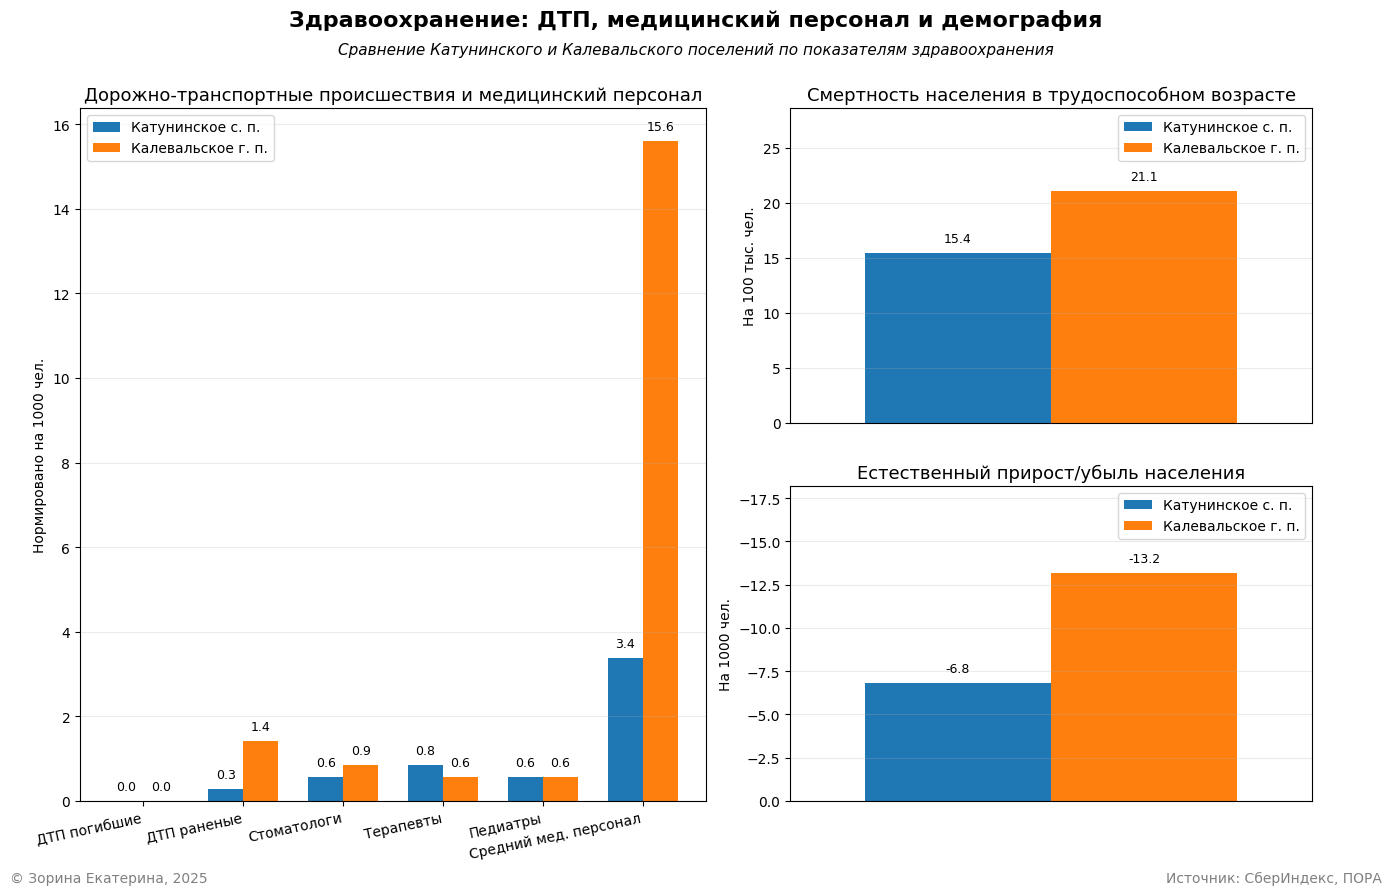

In [15]:
left_width = 1.2
right_width = 1.0
top_height = 1.0
bottom_height = 1.0

settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

settlement_col = 'municipality_down_name'

data = pora_sber.loc[
    pora_sber[settlement_col].isin(settlements_full),
    [
        settlement_col,
        'dtp_deaths_norm',
        'dtp_injury_norm',
        'dentists',
        'terapists',
        'pediatricians',
        'support_staff',
        'death_rate',
        'natural_growth'
    ]
].set_index(settlement_col).T.to_dict(orient='list')

w_total = left_width + right_width
h_total = top_height + bottom_height

left_margin = 0.06
right_margin = 0.06
bottom_margin = 0.10
top_margin = 0.20
middle_gap = 0.06
vertical_gap = 0.07

avail_w = 1.0 - left_margin - right_margin - middle_gap
avail_h = 1.0 - top_margin - bottom_margin

left_w_frac = (left_width / w_total) * avail_w
right_w_frac = (right_width / w_total) * avail_w

top_h_frac = (top_height / h_total) * avail_h
bottom_h_frac = (bottom_height / h_total) * avail_h

left_pos = [left_margin, bottom_margin, left_w_frac, top_h_frac + bottom_h_frac + vertical_gap]
right_top_pos = [left_margin + left_w_frac + middle_gap,
                 bottom_margin + bottom_h_frac + vertical_gap,
                 right_w_frac, top_h_frac]
right_bottom_pos = [left_margin + left_w_frac + middle_gap, bottom_margin, right_w_frac, bottom_h_frac]

fig = plt.figure(figsize=(14, 9))

# левая диаграмма
ax1 = fig.add_axes(left_pos)
x = np.arange(6)
width = 0.35

b1 = ax1.bar(x - width/2,
             [data[settlements_full[0]][0], 
              data[settlements_full[0]][1],
              data[settlements_full[0]][2],
              data[settlements_full[0]][3],
              data[settlements_full[0]][4],
              data[settlements_full[0]][5]],
             width, label=settlements_short[0])

b2 = ax1.bar(x + width/2,
             [data[settlements_full[1]][0],
              data[settlements_full[1]][1],
              data[settlements_full[1]][2],
              data[settlements_full[1]][3],
              data[settlements_full[1]][4],
              data[settlements_full[1]][5]],
             width, label=settlements_short[1])

for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax1.annotate(f"{h:.1f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels(['ДТП погибшие', 'ДТП раненые', 'Стоматологи', 'Терапевты', 'Педиатры', 'Средний мед. персонал'], rotation=12, ha='right')
ax1.set_ylabel('Нормировано на 1000 чел.')
ax1.set_title('Дорожно-транспортные происшествия и медицинский персонал', fontsize=13)
ax1.legend()
ax1.grid(axis='y', alpha=0.25)

# правая верхняя диаграмма
ax2 = fig.add_axes(right_top_pos)
x2 = np.arange(1)
width2 = 0.35

b21 = ax2.bar(x2 - width2/2, [data[settlements_full[0]]
              [6]], width2, label=settlements_short[0])
b22 = ax2.bar(x2 + width2/2, [data[settlements_full[1]]
              [6]], width2, label=settlements_short[1])

for bars in (b21, b22):
    for bar in bars:
        h = bar.get_height()
        ax2.annotate(f"{h:.1f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax2.set_xticks([])
ax2.set_ylabel('На 100 тыс. чел.')
ax2.margins(x=0.2)
ax2.set_ylim(0, 22 * 1.3)
ax2.set_title('Смертность населения в трудоспособном возрасте', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.25)

# правая нижняя диаграмма
ax3 = fig.add_axes(right_bottom_pos)
x3 = np.arange(1)
width3 = 0.4

b31 = ax3.bar(x3 - width3/2, [data[settlements_full[0]][7]], width3, label=settlements_short[0])
b32 = ax3.bar(x3 + width3/2, [data[settlements_full[1]][7]], width3, label=settlements_short[1])

for bars in (b31, b32):
    for bar in bars:
        h = bar.get_height()
        ax3.annotate(f"{h:.1f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax3.set_xticks([])
ax3.set_ylabel('На 1000 чел.')
ax3.margins(x=0.2)
ax3.set_ylim(0, -14 * 1.3)
ax3.set_title('Естественный прирост/убыль населения', fontsize=13)
ax3.legend()
ax3.grid(axis='y', alpha=0.25)

fig.suptitle('Здравоохранение: ДТП, медицинский персонал и демография', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93, 'Сравнение Катунинского и Калевальского поселений по показателям здравоохранения', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, 0.01, '© Зорина Екатерина, 2025', ha='left', fontsize=10, color='gray')
plt.figtext(0.99, 0.01, 'Источник: СберИндекс, ПОРА', ha='right', fontsize=10, color='gray')

plt.show()

Катунинское сельское поселение

- ДТП: Показатели смертности в ДТП равны 0, что означает отсутствие погибших за рассматриваемый период, а число раненых — 0,28 на 1000 человек, что крайне низко.

- Смертность населения в трудоспособном возрасте: 15,4 на 100 тыс. населения, что относительно умеренный показатель.

- Естественный прирост: -6,8 на 1000 человек, указывающий на сокращение численности населения.

Калевальское городское поселение

- ДТП: Смертность также равна 0, однако количество раненых выше — 1,42 на 1000 человек, что в 5 раз превышает показатель Катунинского поселения.

- Смертность населения в трудоспособном возрасте: 21,1 на 100 тыс. населения — заметно выше, чем в Катунинском поселении.

- Естественный прирост: -13,2 на 1000 человек, что отражает более сильное сокращение численности населения.


Калевальское поселение демонстрирует более высокие показатели травматизма и смертности среди трудоспособного населения, а также более интенсивное сокращение численности населения по сравнению с Катунинским. Катунинское поселение характеризуется относительно низким уровнем ДТП и умеренной смертностью, однако оба населённых пункта сталкиваются с отрицательным естественным приростом, что указывает на демографические вызовы в регионе. В целом, здравоохранение и безопасность на дорогах в Катунинском поселении выглядят более благополучно, а Калевальское требует повышенного внимания к профилактике травматизма и укреплению системы здравоохранения. Несмотря на это в Калевальском поселении большее количество врачей.

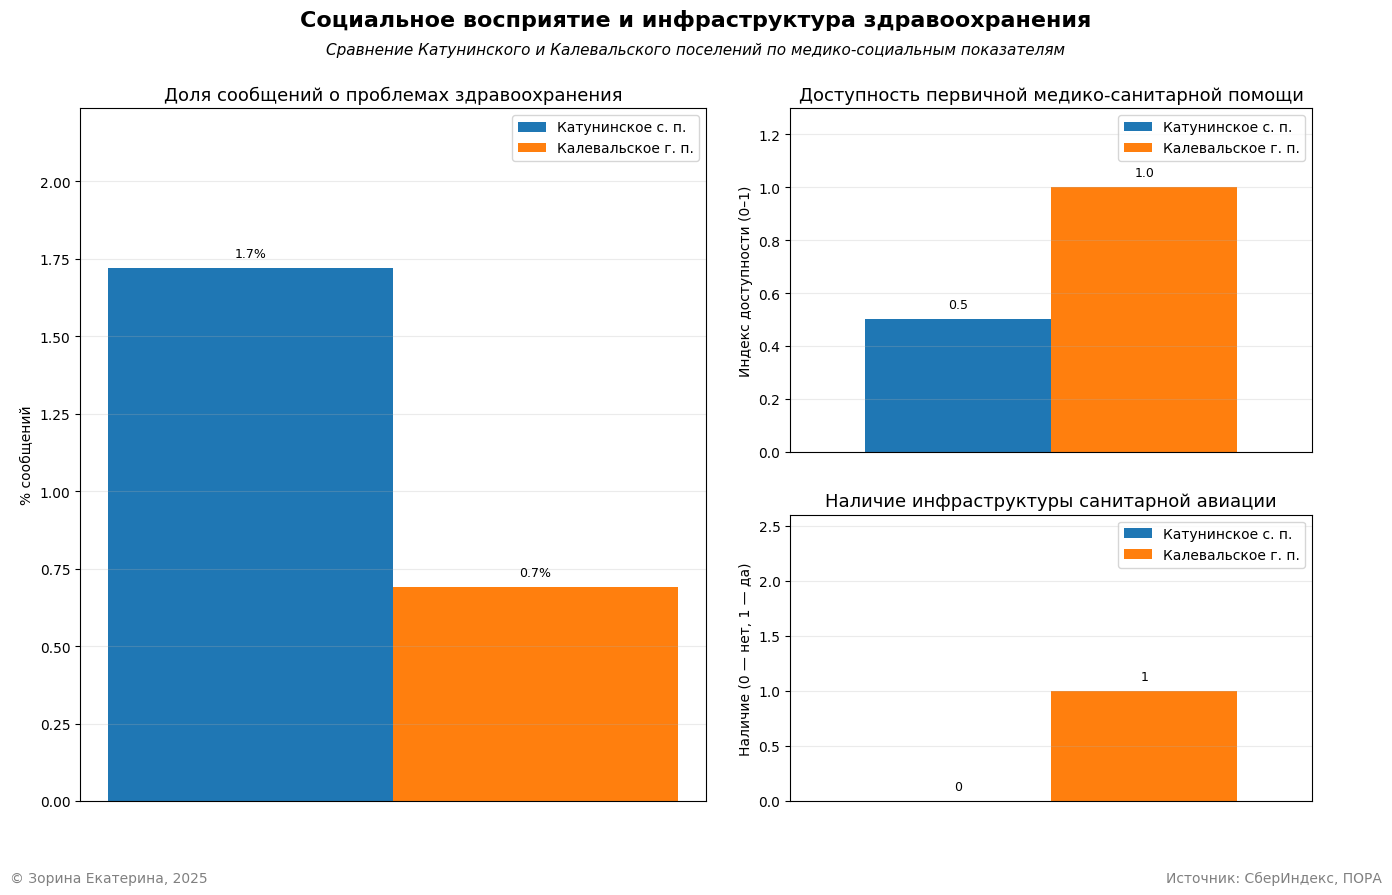

In [16]:
left_width = 1.2
right_width = 1.0
top_height = 1.2
bottom_height = 1.0

settlements_full = ['Катунинское сельское поселение', 'Калевальское городское поселение']
settlements_short = ['Катунинское с. п.', 'Калевальское г. п.']

settlement_col = 'municipality_down_name'

data = pora_sber.loc[
    pora_sber[settlement_col].isin(settlements_full),
    [
        settlement_col,
        'comments_health_perc',
        'primary_avaiability',
        'aviation_sun'
    ]
].set_index(settlement_col).T.to_dict(orient='list')

w_total = left_width + right_width
h_total = top_height + bottom_height

left_margin = 0.06
right_margin = 0.06
bottom_margin = 0.10
top_margin = 0.20
middle_gap = 0.06
vertical_gap = 0.07

avail_w = 1.0 - left_margin - right_margin - middle_gap
avail_h = 1.0 - top_margin - bottom_margin

left_w_frac = (left_width / w_total) * avail_w
right_w_frac = (right_width / w_total) * avail_w

top_h_frac = (top_height / h_total) * avail_h
bottom_h_frac = (bottom_height / h_total) * avail_h

left_pos = [left_margin, bottom_margin, left_w_frac, top_h_frac + bottom_h_frac + vertical_gap]
right_top_pos = [left_margin + left_w_frac + middle_gap,
                 bottom_margin + bottom_h_frac + vertical_gap,
                 right_w_frac, top_h_frac]
right_bottom_pos = [left_margin + left_w_frac + middle_gap, bottom_margin, right_w_frac, bottom_h_frac]

fig = plt.figure(figsize=(14, 9))

# левая таблица
ax1 = fig.add_axes(left_pos)
x = np.arange(1)
width = 0.35

b1 = ax1.bar(x - width/2, [data[settlements_full[0]][0]], width, label=settlements_short[0])
b2 = ax1.bar(x + width/2, [data[settlements_full[1]][0]], width, label=settlements_short[1])

for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax1.annotate(f"{h:.1f}%", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax1.set_xticks([])
ax1.set_ylabel('% сообщений')
ax1.set_ylim(0, max(data[settlements_full[0]][0], data[settlements_full[1]][0]) * 1.3)
ax1.set_title('Доля сообщений о проблемах здравоохранения', fontsize=13)
ax1.legend()
ax1.grid(axis='y', alpha=0.25)

# правая верхняя таблица
ax2 = fig.add_axes(right_top_pos)
x2 = np.arange(1)
width2 = 0.35

b21 = ax2.bar(x2 - width2/2, [data[settlements_full[0]][1]], width2, label=settlements_short[0])
b22 = ax2.bar(x2 + width2/2, [data[settlements_full[1]][1]], width2, label=settlements_short[1])

for bars in (b21, b22):
    for bar in bars:
        h = bar.get_height()
        ax2.annotate(f"{h:.1f}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax2.set_xticks([])
ax2.set_ylabel('Индекс доступности (0–1)')
ax2.margins(x=0.2)
ax2.set_ylim(0, 1.3)
ax2.set_title('Доступность первичной медико-санитарной помощи', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.25)

# правая нижняя таблица
ax3 = fig.add_axes(right_bottom_pos)
x3 = np.arange(1)
width3 = 0.4

b31 = ax3.bar(x3 - width3/2, [data[settlements_full[0]][2]], width3, label=settlements_short[0])
b32 = ax3.bar(x3 + width3/2, [data[settlements_full[1]][2]], width3, label=settlements_short[1])

for bars in (b31, b32):
    for bar in bars:
        h = bar.get_height()
        ax3.annotate(f"{int(h)}", xy=(bar.get_x() + bar.get_width()/2, h),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

ax3.set_xticks([])
ax3.set_ylabel('Наличие (0 — нет, 1 — да)')
ax3.margins(x=0.2)
ax3.set_ylim(0, 2 * 1.3)
ax3.set_title('Наличие инфраструктуры санитарной авиации', fontsize=13)
ax3.legend()
ax3.grid(axis='y', alpha=0.25)

fig.suptitle('Социальное восприятие и инфраструктура здравоохранения', fontsize=16, fontweight='bold', y=0.98)
fig.text(0.5, 0.93, 'Сравнение Катунинского и Калевальского поселений по медико-социальным показателям', ha='center', fontsize=11, style='italic')

plt.figtext(0.01, 0.01, '© Зорина Екатерина, 2025', ha='left', fontsize=10, color='gray')
plt.figtext(0.99, 0.01, 'Источник: СберИндекс, ПОРА', ha='right', fontsize=10, color='gray')

plt.show()

В Катунинском сельском поселении отмечается высокая доля упоминаний о проблемах здравоохранения (1,7%), что более чем вдвое превышает показатель Калевальского (0,7%). Это свидетельствует о более низкой удовлетворённости качеством медицинских услуг или доступностью медицинской помощи.
При этом доступность первичной медико-санитарной помощи в Катунинском поселении — средняя (0,5), тогда как в Калевальском — максимальная (1,0).
Кроме того, санитарная авиация отсутствует в Катунинском поселении (0,0), но присутствует в Калевальском (1,0), что создаёт дополнительные возможности для экстренной медицинской эвакуации и поддержки в труднодоступных районах.

Обобщающий вывод:
Сравнение показывает, что Калевальское городское поселение обладает более развитой медицинской инфраструктурой и высокой доступностью медицинских услуг, что отражается в меньшем количестве негативных упоминаний о здравоохранении.
Напротив, Катунинское сельское поселение демонстрирует меньшую доступность медицины и отсутствие санитарной авиации, что вероятно влияет на рост числа жалоб и формирует менее благоприятное восприятие состояния здравоохранения среди жителей.